In [ ]:
! pip install -Uq kaggle

In [1]:
! pip install -Uq fastai

In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luciancotolan","key":"0212046bcfc9607ecdc37e93d8bdb037"}'}

In [ ]:
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download nikitarom/planets-dataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [2]:
!unzip drive/MyDrive/AmazonImages/planets-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: test-jpg-additional/test-jpg-additional/file_5499.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_55.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_550.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5500.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5501.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5502.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5503.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5504.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5505.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5506.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5507.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5508.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5509.jpg  
  inflating: test-jpg-additional/test-jpg-additional/fi

In [1]:
from fastai.vision.all import *
path = Path('./planet/planet')

In [ ]:
path.ls()

(#4) [Path('planet/planet/train_classes.csv'),Path('planet/planet/train-jpg'),Path('planet/planet/sample_submission.csv'),Path('planet/planet/test-jpg')]

In [4]:
train_df = pd.read_csv(path/'train_classes.csv')
train_df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


Drop images that are cloudy

In [5]:
train_df.drop(train_df[train_df["tags"] == "cloudy"].index, inplace=True)
#if the tags column contains the word 'habitation' then drop that row
train_df.drop(train_df[train_df["tags"].str.contains("habitation")].index, inplace=True)
train_df.drop(train_df[train_df["tags"].str.contains("haze")].index, inplace=True)

In [6]:
import pandas as pd

# lista de labels care sunt deforestare
keywords = ["agriculture","artisinal_mine","conventional_mine","cultivation","road","selective_logging","slash_burn"]

def check_tags(tags):
    for keyword in keywords:
        if keyword in tags:
            return "deforestation"
    return "not_deforestation"

# aplicam functia pe coloana tags pentru a crea coloana label
train_df["label"] = train_df["tags"].apply(check_tags)
train_df

,image_name,tags,label
1,train_1,agriculture clear primary water,deforestation
2,train_2,clear primary,not_deforestation
3,train_3,clear primary,not_deforestation
6,train_6,agriculture clear cultivation primary water,deforestation
8,train_8,agriculture clear cultivation primary,deforestation
...,...,...,...
40472,train_40472,agriculture clear primary,deforestation
40474,train_40474,clear primary,not_deforestation
40476,train_40476,agriculture clear primary,deforestation
40477,train_40477,agriculture clear primary road,deforestation


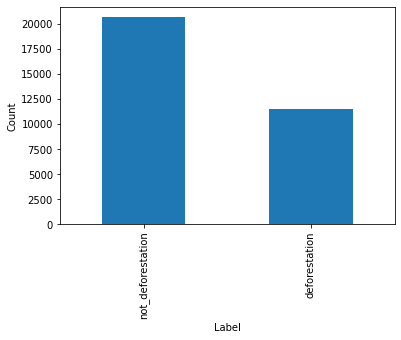

In [7]:
import matplotlib.pyplot as plt

counts = train_df["label"].value_counts()
counts.plot(kind='bar')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [8]:
def get_data(size=224,bs=64,data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=RandomSplitter(seed=42),
                       get_x=ColReader(0, pref=f'{path}/train-jpg/', suff='.jpg'),
                       get_y=ColReader(2),
                       item_tfms = Resize(size),
                       batch_tfms = [*aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.),
                                     Normalize.from_stats(*imagenet_stats)]
                      )
    return dblock.dataloaders(data_df,bs=bs)

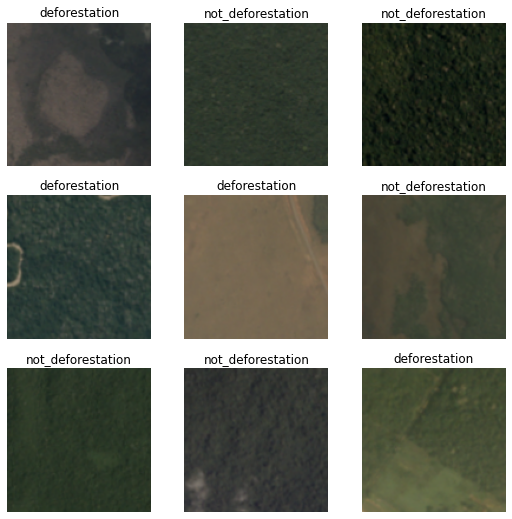

In [9]:
dls = get_data(224,64)
dls.show_batch()

In [10]:
f1score = F1Score(average='binary')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0003311311302240938)

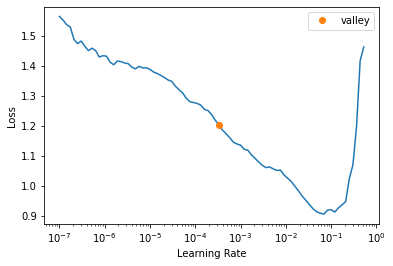

In [11]:
learn = vision_learner(dls, resnet50, metrics=[f1score]).to_fp16()
learn.lr_find()

In [12]:
learn.fine_tune(7, base_lr = 0.0003  ,freeze_epochs=4)

epoch,train_loss,valid_loss,f1_score,time
0,0.725114,0.427099,0.874626,01:56
1,0.557739,0.375541,0.892814,01:51
2,0.483713,0.341027,0.901667,01:55
3,0.404604,0.305717,0.906903,01:48


epoch,train_loss,valid_loss,f1_score,time
0,0.352323,0.283695,0.915234,01:54
1,0.310173,0.258513,0.923278,01:51
2,0.280167,0.243484,0.926057,01:58
3,0.248020,0.234314,0.926346,01:52
4,0.236187,0.230062,0.932502,01:51
5,0.227123,0.225157,0.930788,01:51
6,0.220906,0.225708,0.932555,01:49


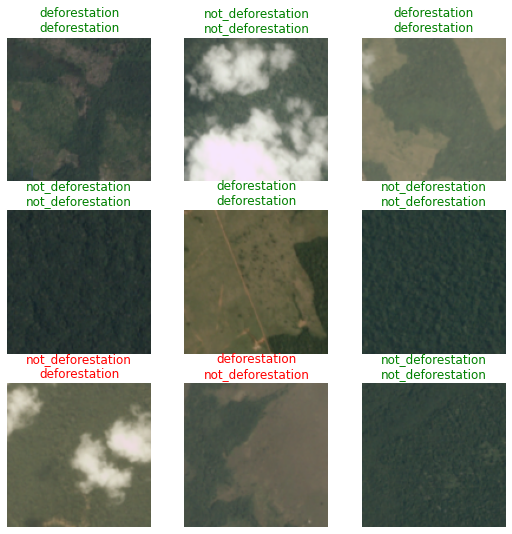

In [ ]:
learn.show_results()

In [ ]:
learn.export('resnet50.pkl')

In [16]:
inference = load_learner('resnet50.pkl', cpu=False)

In [20]:
inference.predict('/content/planet/planet/train-jpg/fragment_S2A_MSIL2A_20220722T092041_N0400_R093_T34TFR_20220722T134859_10_37.jpg')

('deforestation', TensorBase(0), TensorBase([0.9346, 0.0654]))